In [276]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from math import log
import matplotlib.pyplot as plt
%matplotlib inline

In [202]:
# read all the words
words = open('names.txt', 'r').read().splitlines()
words = list(set(words))
reversed_words = list(map(lambda w:w[::-1], words))

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

print(len(words))
print(vocab_size)
print(itos)

# build the dataset
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = 0
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = ix
    X = F.one_hot(torch.tensor(X), num_classes=vocab_size).float()
    Y = torch.tensor(Y)
    return X, Y

build_dataset(random.sample(words, 2))

29494
27
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


(tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0

In [360]:
# create and train the initial model population

pop_size = 32
train_size = 1024

batch_size = 64
n_epochs = 100
lr = 10.

models = [torch.randn((vocab_size, vocab_size), requires_grad=True) for _ in range(pop_size)]

for model in models:
    
    # dataset construct
    data_X, data_Y = build_dataset(random.sample(words, train_size))
    
    # begin optimization
    for _ in range(n_epochs):
        
        # minibatch construct
        ix = torch.randint(0, data_Y.shape[0], (batch_size,))
        Xb, Yb = data_X[ix], data_Y[ix]
        
        # forward pass
        Xb_norm = Xb * ((Xb + 1e-5)**2).sum(1, keepdim=True)**-0.5
        logits = Xb_norm @ model
        loss = F.cross_entropy(logits, Yb)
        
        # backward pass
        loss.backward()
        model.data += -lr * model.grad
        model.grad = None

In [361]:
for model in models:
    model.requires_grad = False

In [362]:
# fitness function based on reversed bigrams
@torch.no_grad()
def fitness_loss(model):
    Xr, Yr = build_dataset(reversed_words)
    logits = Xr @ model
    loss =  F.cross_entropy(logits, Yr)
    return loss.item()

fitness_loss_list = sorted(map(fitness_loss, models))
print(min(fitness_loss_list), max(fitness_loss_list))

3.0140042304992676 3.127201557159424


In [396]:
n_generations = 1
n_children = 16
n_batches = 100
n_epochsX = 50
lrX = 10.

for _ in range(n_generations):
    
    # create untrained children
    children = [torch.randn((vocab_size, vocab_size), requires_grad=True) for _ in range(n_children)]

    for child in children:

        # choose parents
        mom, dad = random.sample(range(len(models)), 2)

        # start training the child
        for _ in range(n_batches):

            # initialize fake data
            Xc = torch.randn((batch_size, vocab_size), requires_grad=True)

            # begin optimizing fake data
            for _ in range(n_epochsX):

                # feed fake data to parents, compare their outputs
                Xc_norm = Xc * ((Xc + 1e-5)**2).sum(1, keepdim=True)**-0.5
                mom_pred, dad_pred = F.log_softmax(Xc_norm @ models[mom], dim=1), F.log_softmax(Xc_norm @ models[dad], dim=1)
                lossX = nn.KLDivLoss(log_target=True, reduction='batchmean')(mom_pred, dad_pred)

                # optimize the data to find "common ground" between parents
                lossX.backward()
                Xc.data += -lrX * Xc.grad
                Xc.grad = None

            # train the child with mom's answer to the optimized fake data
            Xc.detach_()
            Xc_norm = Xc * ((Xc + 1e-5)**2).sum(1, keepdim=True)**-0.5
            Yc = F.log_softmax(Xc_norm @ models[mom], dim=1)
            child_pred = F.log_softmax(Xc_norm @ child, dim=1)
            loss = nn.KLDivLoss(log_target=True, reduction='batchmean')(child_pred, Yc)
            loss.backward()
            child.data += -lrX * child.grad
            child.grad = None
    
    # add children to the population
    for child in children:
        child.requires_grad = False
    models = models + children
    
    # kill the unfit
    models.sort(key=fitness_loss)
    models = models[:pop_size]
    
    print("A generation has passed.")

A generation has passed.


In [397]:
fitness_loss_list = sorted(map(fitness_loss, models))
print(min(fitness_loss_list), max(fitness_loss_list))

2.9641265869140625 2.998692274093628


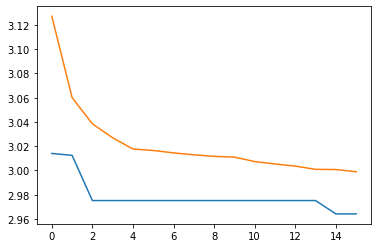

16

In [399]:
mins = [3.0140042304992676, 3.0124454498291016, 2.9751508235931396, 2.9751508235931396, 2.9751508235931396, 2.9751508235931396, 2.9751508235931396, 2.9751508235931396, 2.9751508235931396, 2.9751508235931396, 2.9751508235931396, 2.9751508235931396, 2.9751508235931396, 2.9751508235931396, 2.9641265869140625, 2.9641265869140625]
maxs = [3.127201557159424, 3.060105323791504, 3.0384182929992676, 3.026933193206787, 3.0176544189453125, 3.016462802886963, 3.01448655128479, 3.012882709503174, 3.011606454849243, 3.0109856128692627, 3.0073330402374268, 3.005284070968628, 3.003586530685425, 3.000889301300049, 3.000751495361328, 2.998920440673828]

plt.plot(mins)
plt.plot(maxs)
plt.show()